In [16]:
import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np
import random

# from utils import get_dataset, average_weights, exp_details
from utils_v2 import get_dataset, average_weights, exp_details

In [17]:
batch_size = 32  # how many samples per batch to load
iid = 1 # if the data is i.i.d or not
unbalanced = 0 # in non i.i.d. setting split the data between clients equally or not
num_users = 100 # number of client

In [18]:
# for REPRODUCIBILITY https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(0)

g = torch.Generator()
g.manual_seed(0)

np.random.seed(0)

In [19]:
train_dataset, test_dataset, user_groups = get_dataset(iid=iid, unbalanced=unbalanced,
                                                       num_users=num_users)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
class DatasetSplit(Dataset):
    """
    An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [21]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [22]:
def get_dataloader(dataset, idxs):
    # idxs_train = idxs[:int(0.9 * len(idxs))]
    # idxs_test = idxs[int(0.9 * len(idxs)):]
    #
    # trainloader = DataLoader(DatasetSplit(dataset, idxs_train),
    #                          batch_size=batch_size, shuffle=True, generator=g,
    #                          worker_init_fn=seed_worker)
    # testloader = DataLoader(DatasetSplit(dataset, idxs_test),
    #                         batch_size=max(int(len(idxs_test) / 10), 1), shuffle=False, generator=g,
    #                         worker_init_fn=seed_worker)
    #
    # return trainloader, testloader
    trainloader = DataLoader(DatasetSplit(dataset, idxs),
                             batch_size=batch_size, shuffle=True, generator=g,
                             worker_init_fn=seed_worker)

    return trainloader

In [23]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [24]:
user_lables = dict()

for idx in user_groups.keys():
    labels_list = []
    #trainloader, _ = get_dataloader(train_dataset, user_groups[idx])
    trainloader = get_dataloader(train_dataset, user_groups[idx])
    for data, target in trainloader:
        for i in range(len(data)):
            label = target.data[i]
            labels_list.append(classes[int(label)])

    user_lables[idx] = labels_list

C:\Users\david\AppData\Local\Temp\ipykernel_11720\3803027819.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


In [25]:
def count_labels(user_labels, classes):
    user_labels_count = dict()
    for idx in user_groups.keys():
        elements_count = {}
        # iterating over the elements for frequency
        for element in user_labels[idx]:
            # checking whether it is in the dict or not
            if element in elements_count:
                # incerementing the count by 1
                elements_count[element] += 1
            else:
                # setting the count to 1
                elements_count[element] = 1

        user_labels_count[idx] = elements_count

    return user_labels_count

user_labels_count = count_labels(user_lables, classes)

In [26]:
import pandas as pd

data = pd.DataFrame.from_dict(user_labels_count, orient="index")

In [27]:
data.sum()

truck         5000
dog           5000
cat           5000
deer          5000
ship          5000
horse         5000
frog          5000
airplane      5000
automobile    5000
bird          5000
dtype: int64

In [28]:
data

,truck,dog,cat,deer,ship,horse,frog,airplane,automobile,bird
0,50,50,50,50,50,50,50,50,50,50
1,50,50,50,50,50,50,50,50,50,50
2,50,50,50,50,50,50,50,50,50,50
3,50,50,50,50,50,50,50,50,50,50
4,50,50,50,50,50,50,50,50,50,50
...,...,...,...,...,...,...,...,...,...,...
95,50,50,50,50,50,50,50,50,50,50
96,50,50,50,50,50,50,50,50,50,50
97,50,50,50,50,50,50,50,50,50,50
98,50,50,50,50,50,50,50,50,50,50


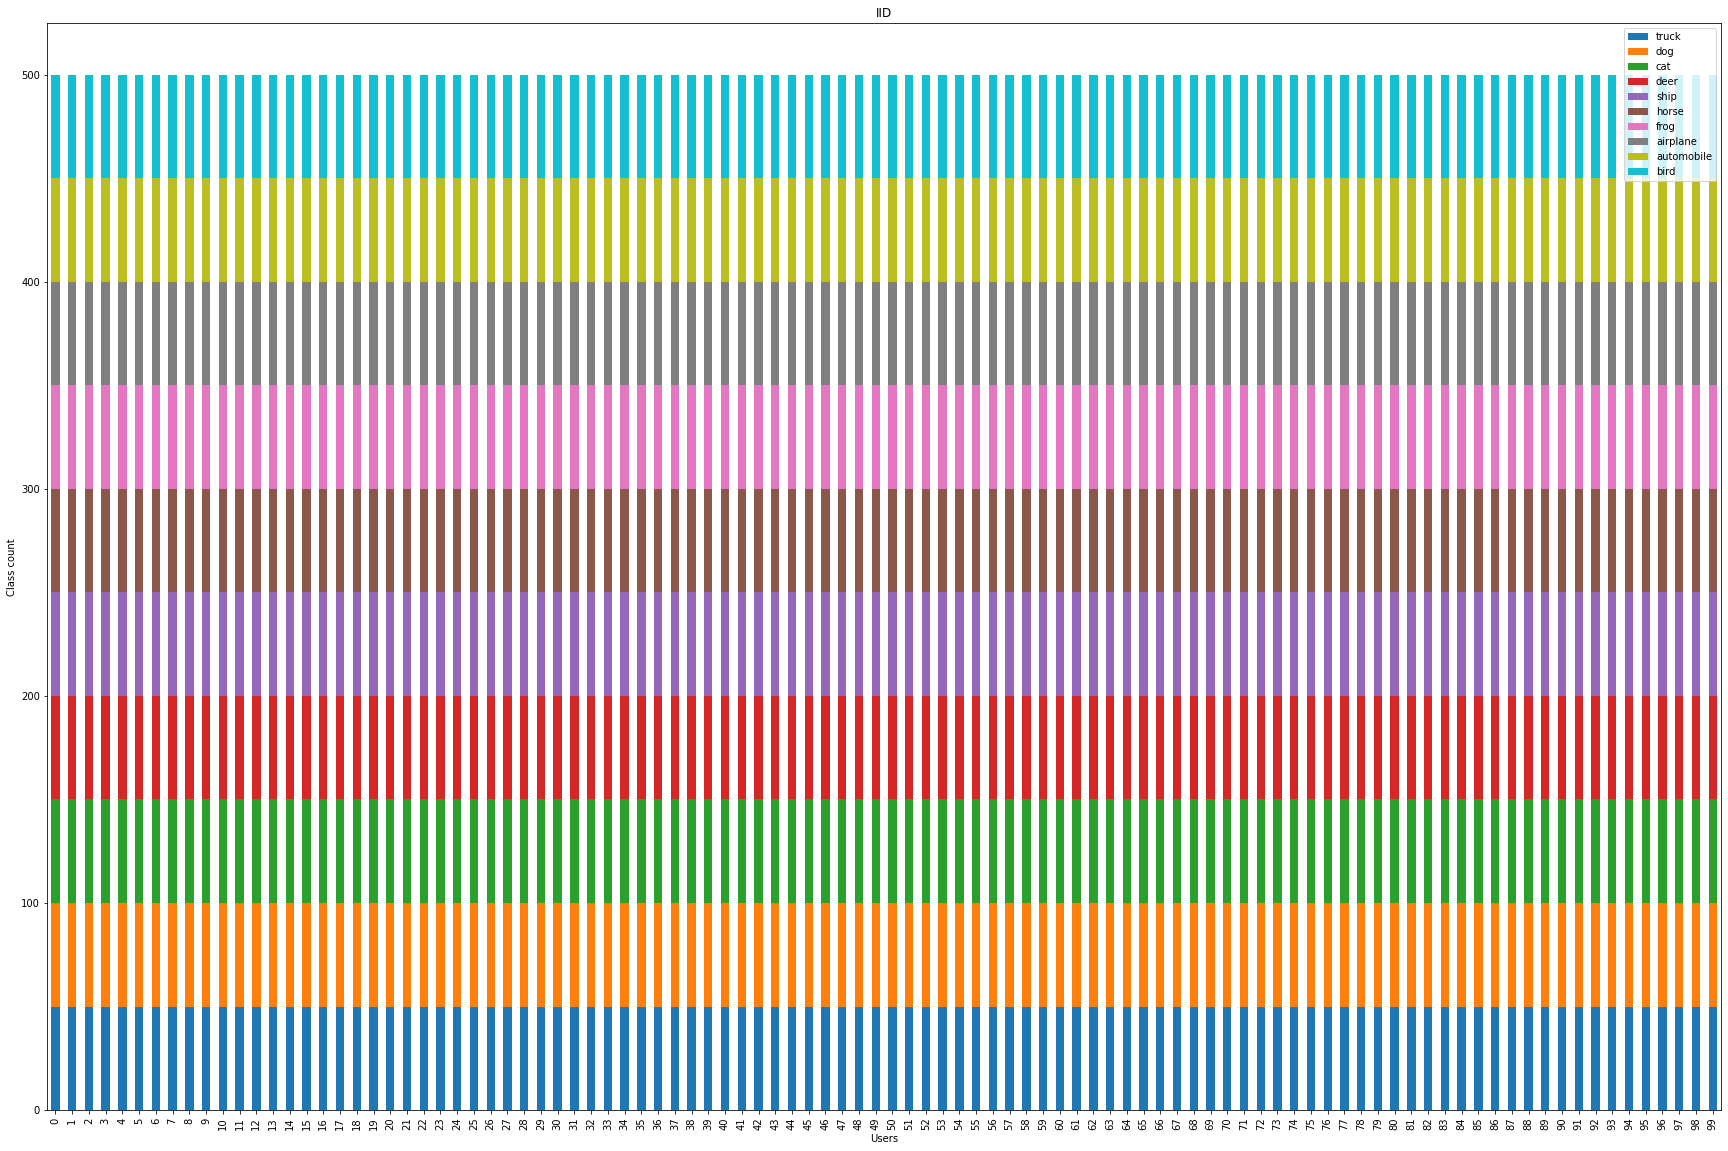

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 20))

data.plot.bar(stacked=True, ax=ax)

plt.title("IID")
plt.ylabel('Class count')
plt.xlabel('Users')

plt.savefig("data_distribution/IID_v2.png")